# 1. Save best result file
# 2. Fix seed number

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Change directory
import os

os.chdir('/gdrive/My Drive/Dacon')
print(os.getcwd())

/gdrive/My Drive/Dacon


In [ ]:
# Load dataset
import pandas as pd

train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(10000, 76)
(10000, 72)


In [ ]:
# Load packages

# Calculation
import numpy as np
import time
from random import randint

# Graph
import matplotlib.pyplot as plt

# seaborn operates only when it's activated
%matplotlib inline
import seaborn as sns 

# Missing
#pip install missingno
import missingno as msno

# Variables
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE

# Model
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.multioutput import MultiOutputRegressor

#pip install lightgbm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor

!pip install vecstack
from vecstack import stacking

print('OK')

OK


# Model scoring

In [ ]:
base_params={'boosting_type': 'dart', 'n_estimators': 900, 'learning_rate': 0.16, 'max_depth': 30, 'subsample': 0.9, 'min_child_samples':60, 
             'colsample_bytree': 0.8, 'num_leaves': 90, 'reg_alpha': 5, 'reg_lambda': 7}

base_model=LGBMRegressor(random_state=453, subsample_freq=1, silent=False, importance_type='gain', **base_params)

multi_model=MultiOutputRegressor(base_model)

def model_scoring_cv(model, x, y, cv=5):
  start= time.time()
  score= -cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
  stop=time.time()
  print(f"Validation Time: {round(stop-start, 0)} sec")
  return score

# Data exploration

In [ ]:
# Id is all unique
print(train['id'].unique().shape)
print(test['id'].unique().shape)

(10000,)
(10000,)


In [ ]:
# rho has 4 values
print(train['rho'].unique())
print(test['rho'].unique())

[25 10 15 20]
[15 10 25 20]


In [ ]:
# All positive values
train.describe()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,8.052000e+03,8.012000e+03,8.069000e+03,8.025000e+03,7.997000e+03,8.034000e+03,8.054000e+03,7.954000e+03,7.994000e+03,8.007000e+03,7.929000e+03,7.950000e+03,8.006000e+03,8.055000e+03,7.941000e+03,7.974000e+03,8.010000e+03,7.909000e+03,8.035000e+03,7.955000e+03,7.986000e+03,7.990000e+03,7.980000e+03,8.032000e+03,7.941000e+03,8.001000e+03,7.970000e+03,7.962000e+03,8.022000e+03,7.982000e+03,7.987000e+03,7.992000e+03,7.931000e+03,8.081000e+03,8.013000e+03,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,17.568000,0.180212,0.203529,0.229804,0.259158,0.289975,0.322244,0.354101,0.384492,0.412503,0.436837,0.457967,0.476572,0.492156,0.505204,0.514847,0.521998,0.526279,0.527803,0.526581,0.522834,0.516752,0.508073,0.497672,0.484489,0.468856,0.450071,0.427684,0.402133,0.373510,0.342931,0.311117,0.279036,0.248194,0.220063,0.194771,1.124878e-11,1.049022e-11,7.149459e-12,5.730763e-12,5.830921e-12,9.800478e-12,1.341997e-11,1.478769e-11,1.872129e-11,1.940671e-11,3.368432e-11,4.103896e-11,6.556870e-11,1.535845e-10,2.534842e-10,3.507968e-10,3.742625e-10,3.442563e-10,2.849591e-10,2.357635e-10,2.230534e-10,2.315210e-10,1.960385e-10,1.280135e-10,7.736184e-11,7.976805e-11,6.761949e-11,6.687656e-11,8.491835e-11,7.511190e-11,4.270426e-11,2.498465e-11,4.047717e-11,1.153774e-10,2.364072e-10,7.990686,4.009146,9.019226,3.042651
std,2886.89568,5.595847,0.272859,0.288661,0.306340,0.324849,0.342362,0.357700,0.370451,0.379054,0.382319,0.381070,0.376649,0.370811,0.364924,0.359392,0.354133,0.350876,0.348416,0.346901,0.346015,0.347224,0.349507,0.353201,0.358563,0.365313,0.372194,0.377802,0.381172,0.381287,0.376981,0.369067,0.356267,0.338620,0.319405,0.299366,0.281410,3.950723e-10,3.552589e-10,1.810768e-10,1.033245e-10,5.532230e-11,1.437367e-10,1.753800e-10,1.267547e-10,1.908160e-10,1.594302e-10,2.911465e-10,3.835104e-10,5.001364e-10,1.053443e-09,1.502732e-09,1.881377e-09,1.948361e-09,1.735492e-09,1.504526e-09,1.310408e-09,1.241880e-09,1.236564e-09,8.995359e-10,6.467676e-10,3.857980e-10,3.778529e-10,3.336177e-10,3.453981e-10,4.335765e-10,3.831916e-10,2.293432e-10,1.639150e-10,2.134495e-10,5.179299e-10,1.058272e-09,2.970818,0.997828,2.979453,1.881872
min,0.00000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e

In [ ]:
# We can see null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 76 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10000 non-null  int64  
 1   rho      10000 non-null  int64  
 2   650_src  10000 non-null  float64
 3   660_src  10000 non-null  float64
 4   670_src  10000 non-null  float64
 5   680_src  10000 non-null  float64
 6   690_src  10000 non-null  float64
 7   700_src  10000 non-null  float64
 8   710_src  10000 non-null  float64
 9   720_src  10000 non-null  float64
 10  730_src  10000 non-null  float64
 11  740_src  10000 non-null  float64
 12  750_src  10000 non-null  float64
 13  760_src  10000 non-null  float64
 14  770_src  10000 non-null  float64
 15  780_src  10000 non-null  float64
 16  790_src  10000 non-null  float64
 17  800_src  10000 non-null  float64
 18  810_src  10000 non-null  float64
 19  820_src  10000 non-null  float64
 20  830_src  10000 non-null  float64
 21  840_src  1000

## There's no duplicated row

In [ ]:
# There is no duplicated observation.
# There are NaNs
train.drop_duplicates()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,740_src,750_src,760_src,770_src,780_src,790_src,800_src,810_src,820_src,830_src,840_src,850_src,860_src,870_src,880_src,890_src,900_src,910_src,920_src,930_src,940_src,950_src,960_src,970_src,980_src,990_src,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,750_dst,760_dst,770_dst,780_dst,790_dst,800_dst,810_dst,820_dst,830_dst,840_dst,850_dst,860_dst,870_dst,880_dst,890_dst,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,1.01541,0.99865,0.94373,0.84513,0.74023,0.68776,0.57697,0.51536,0.43508,0.36501,0.34935,0.30038,0.26992,0.23192,0.21998,0.19920,0.14493,0.13150,0.12442,0.10786,0.11984,0.09851,0.10965,0.07424,0.07777,0.05536,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,NaN,0.000000e+00,NaN,0.000000e+00,5.901745e-18,NaN,1.176812e-18,NaN,5.557492e-17,1.046498e-16,NaN,7.236748e-17,4.021610e-17,2.397489e-17,1.870153e-17,1.808920e-17,NaN,0.000000e+00,2.626216e-18,NaN,3.527371e-18,NaN,6.455564e-19,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,0.01295,0.00000,0.01565,0.00000,0.00000,0.01285,0.01129,0.00359,0.00000,0.00000,0.00000,0.00000,0.00000,0.04466,0.10738,0.21646,0.41456,0.63716,0.84230,0.97480,0.99803,0.97146,0.87045,0.75330,0.63414,0.53699,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,1.151021e-10,4.318673e-10,2.753933e-10,0.000000e+00,8.138830e-10,6.522110e-10,NaN,2.732232e-10,NaN,7.663267e-11,NaN,1.389496e-10,1.472282e-09,1.450463e-09,1.225321e-09,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,0.30445,0.38962,0.50472,0.56934,0.67742,0.79720,0.87593,0.92783,0.99498,0.98682,0.98988,0.95101,0.89853,0.79813,0.68262,0.58043,0.46222,0.39113,0.27879,0.19070,0.16603,0.11617,0.06744,0.02343,0.03926,0.03136,1.677445e-19,3.763590e-20,NaN,0.000000e+00,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,3.349335e-19,NaN,0.000000e+00,2.630961e-18,NaN,0.000000e+00,9.912979e-18,1.112747e-17,NaN,NaN,NaN,1.260239e-19,NaN,0.000000e+00,3.876159e-18,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,0.91482,0.95274,0.99391,1.00563,0.93165,0.84703,0.74997,0.67765,0.58432,0.50642,0.43087,0.35684,0.30786,0.27722,0.24119,0.20158,0.17876,0.15139,0.15656,0.13392,0.14247,0.10126,0.09928,0.09239,0.10523,0.06349,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,1.678049e-10,2.814419e-10,4.429321e-10,1.319956e-09,2.269806e-09,2.679164e-09,2.538200e-09,2.046841e-09,1.516820e-09,1.328007e-09,1.061359e-09,8.634016e-10,5.804951e-10,3.615067e-10,NaN,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,1.00216,1.01190,1.00344,0.98365,1.01350,1.01649,0.98220,0.99091,0.99258,1.00175,0.98861,0.98270,1.00432,1.01434,1.01455,0.98861,0.98300,1.00616,0.99045,1.01321,1.01559,1.01072,0.99439,0.98597,0.99889,1.01412,4.784751e-14,NaN,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,0.000000e+00,2.666663e-14,1.493071e-14,NaN,0.000000e+00,1.200730e-13,2.648249e-13,NaN,4.392331e-13,2.831191e-13,4.557059e-13,1.326038e-13,1.864796e-13,1.419359e-13,1.765559e-13,1.593789e-13,NaN,0.000000e+00,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.9

In [ ]:
test.drop_duplicates().shape

(10000, 72)

## Are src always bigger than dst?

In [ ]:
cnt= 0
for feature in np.arange(650, 1000, 10):
  cnt += (train[str(feature)+'_src'] < train[str(feature)+'_dst']).sum()

cnt

12314

In [ ]:
(train['650_src'] < train['650_dst']).sum()

674

In [ ]:
# Where the src value is zero
train.loc[train['650_src'] < train['650_dst'], ['650_src', '650_dst']]

,650_src,650_dst
2,0.0,1.677445e-19
9,0.0,2.723855e-20
13,0.0,2.468582e-12
16,0.0,1.471178e-19
26,0.0,1.231161e-19
...,...,...
9939,0.0,2.716037e-16
9943,0.0,5.285391e-15
9963,0.0,1.210934e-18
9979,0.0,5.619065e-16


# Change to the lower value

In [ ]:
for feature in np.arange(650, 1000, 10):
  for obs in range(10000):
    if train.loc[obs, str(feature)+'_src'] < train.loc[obs, str(feature)+'_dst']:
      train.loc[obs, str(feature)+'_dst']= train.loc[obs, str(feature)+'_src']

    if test.loc[obs, str(feature)+'_src'] < test.loc[obs, str(feature)+'_dst']:
      test.loc[obs, str(feature)+'_dst']= test.loc[obs, str(feature)+'_src']

# Meta data

In [ ]:
data= []

for i in train.columns:
    # Defining the role
    if i in (set(train.columns) - set(test.columns)):
        role = 'target'
    elif i == 'id':
        role= 'id'
    else:
        role= 'input'
        
    # All numeric -> skip level
        
    # Initialize keep to Ture, except for id
    keep =True
    if i == 'id':
        keep=False
    
    # Defining the data type
    dtype = train[i].dtype
    
    # Defining the group of variable
    if 'src' in i:
        group= 'src'
    elif 'dst' in i:
        group= 'dst'
    else:
        group= i
    
    # Creating a dict for the variables
    i_dict = {
        'varname': i,
        'role': role,
        'keep': keep,
        'dtype': dtype,
        'group': group
        }
    
    data.append(i_dict)
    
meta= pd.DataFrame(data, columns= ['varname', 'role', 'keep', 'dtype', 'group'])
meta.set_index('varname', inplace=True) # When called, it returns varnames instead of numbers
meta

,role,keep,dtype,group
varname,,,,
id,id,False,int64,id
rho,input,True,int64,rho
650_src,input,True,float64,src
660_src,input,True,float64,src
670_src,input,True,float64,src
...,...,...,...,...
990_dst,input,True,float64,dst
hhb,target,True,float64,hhb
hbo2,target,True,float64,hbo2


In [ ]:
meta.groupby(['role', 'group']).size()

role    group
id      id        1
input   dst      35
        rho       1
        src      35
target  ca        1
        hbo2      1
        hhb       1
        na        1
dtype: int64

In [ ]:
pd.DataFrame({'count': meta.groupby(['role', 'group']).size()})

count
role   group       
id     id         1
input  dst       35
       rho        1
       src       35
target ca         1
       hbo2       1
       hhb        1
       na         1

# Target

In [ ]:
target= meta[meta.role=='target'].index
train_y= train[target]

# Inputs

In [ ]:
inputs= meta[(meta.role=='input') & meta.keep].index
train= train[inputs]
test= test[inputs]

In [ ]:
src_dst= meta[(meta.group=='src') | (meta.group=='dst')].index

## src

In [ ]:
src= meta[meta.group=='src'].index

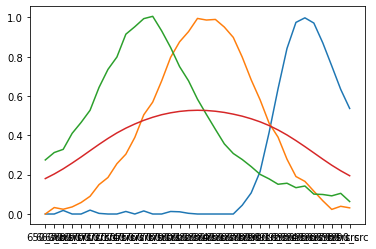

In [ ]:
# Why different???
plt.plot(train.loc[1, src])
plt.plot(train.loc[2, src])
plt.plot(train.loc[3, src])

plt.plot(train[src].mean())

## dst

In [ ]:
dst= meta[meta.group=='dst'].index

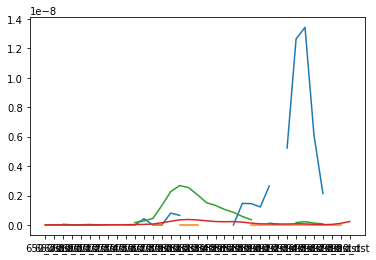

In [ ]:
plt.plot(train.loc[1, dst])
plt.plot(train.loc[2, dst])
plt.plot(train.loc[3, dst])

plt.plot(train[dst].mean())

<Figure size 432x288 with 0 Axes>

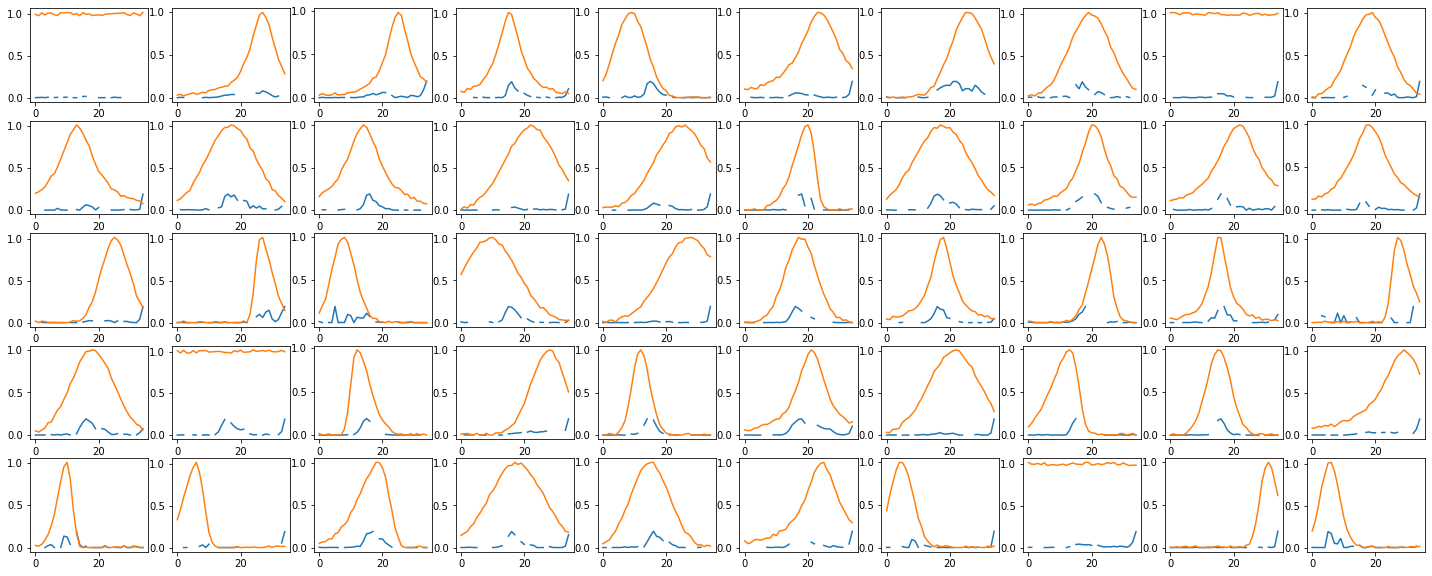

In [ ]:
plt.figure()
fig, ax = plt.subplots(5, 10, figsize=(25, 10))

i=0
for obs in np.arange(200, 250):
  i += 1
  plt.subplot(5,10,i)
  x= train.loc[obs, dst]
  x= (x-0)/(x.max()-0) * 0.19 # 0 -> x.min()
  plt.plot(range(35), x)
  #plt.plot(range(35), train.loc[obs, dst]) # Looks like 0 values
  plt.plot(range(35), train.loc[obs, src])

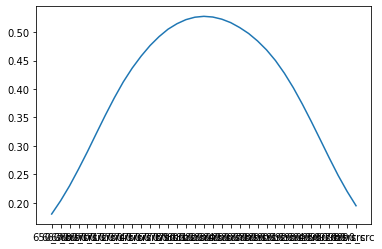

In [ ]:
# Replace parallel src with mean or remove???
plt.plot(train[src].mean())

# Correlation plot

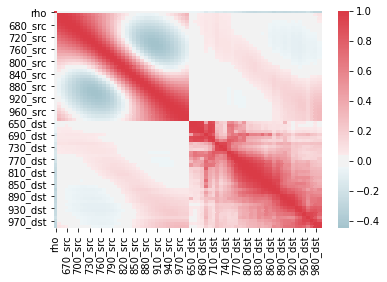

In [ ]:
cmap=sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train[inputs].corr(), center= 0, annot=False, cmap=cmap)
# As it's series no Dimension reduction

# Density plot of variables in train & test

<Figure size 432x288 with 0 Axes>

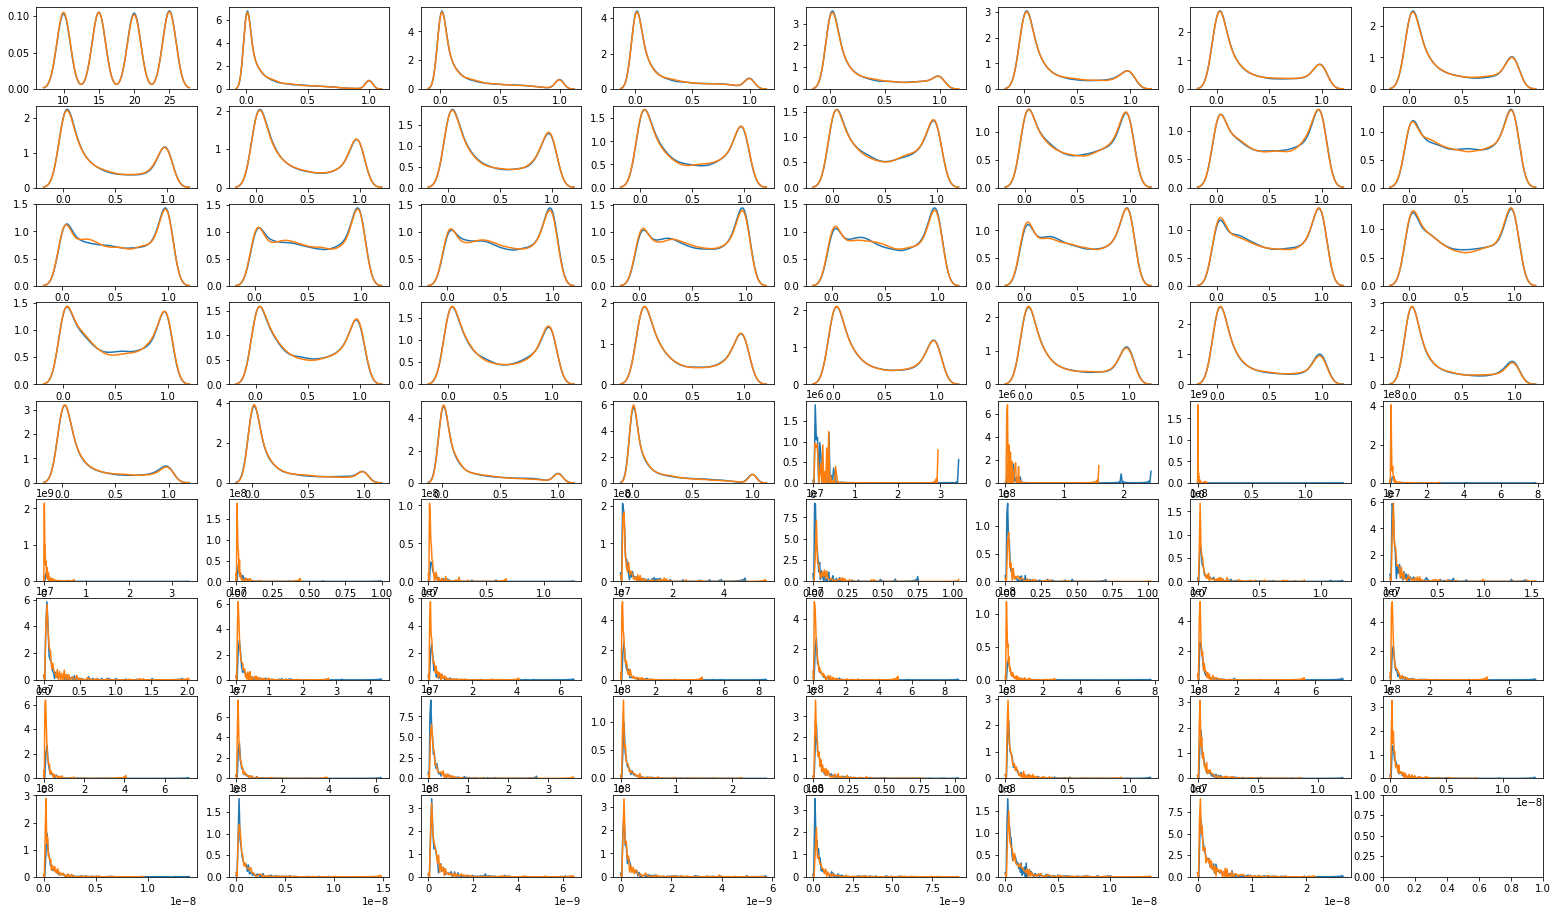

In [ ]:
# There are differences in dst.
# Maybe because of the missing values.
plt.figure()
fig, ax = plt.subplots(9, 8, figsize=(27, 16)) # figsize=(h, v)

i= 0
for feature in inputs:
    i += 1
    plt.subplot(9, 8, i) # ith location in 9 by 8
    
    sns.kdeplot(train[feature], legend=False) #label="train"
    sns.kdeplot(test[feature], legend=False)# bw=0.5 sets the location of legend
    #plt.ylabel('Density plot', fontsize= 10) #invades the region
    #plt.xlabel(feature, fontsize= 10)
plt.show();

# Missing values

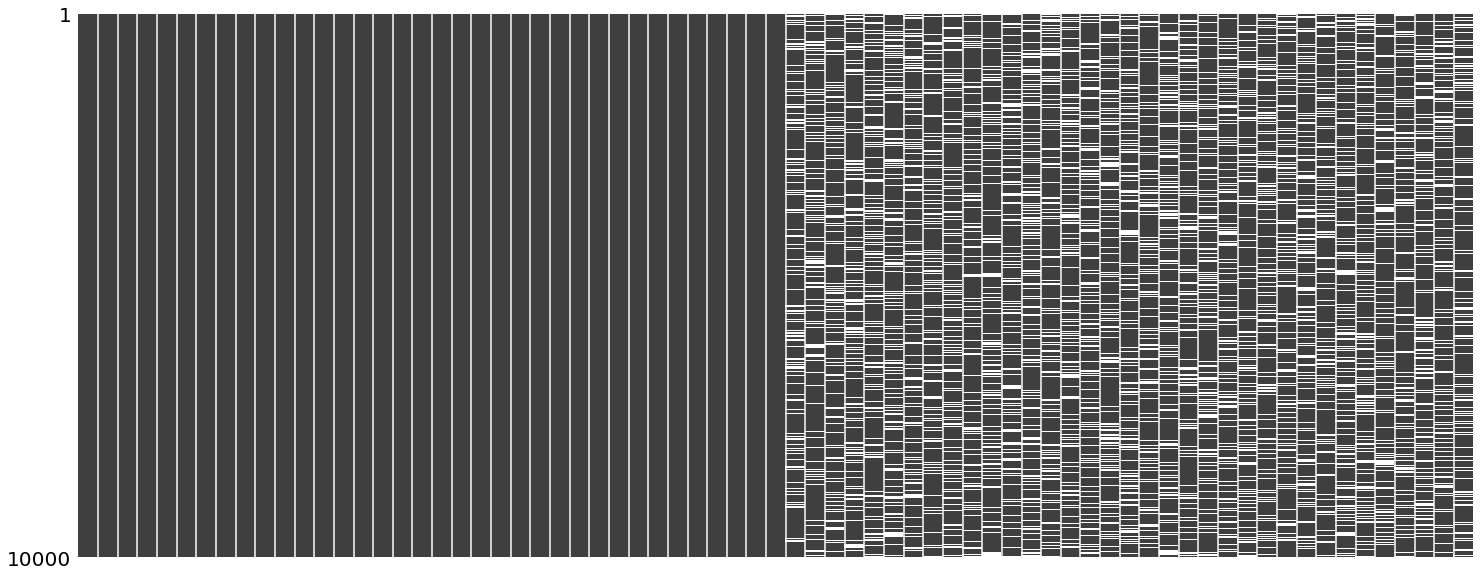

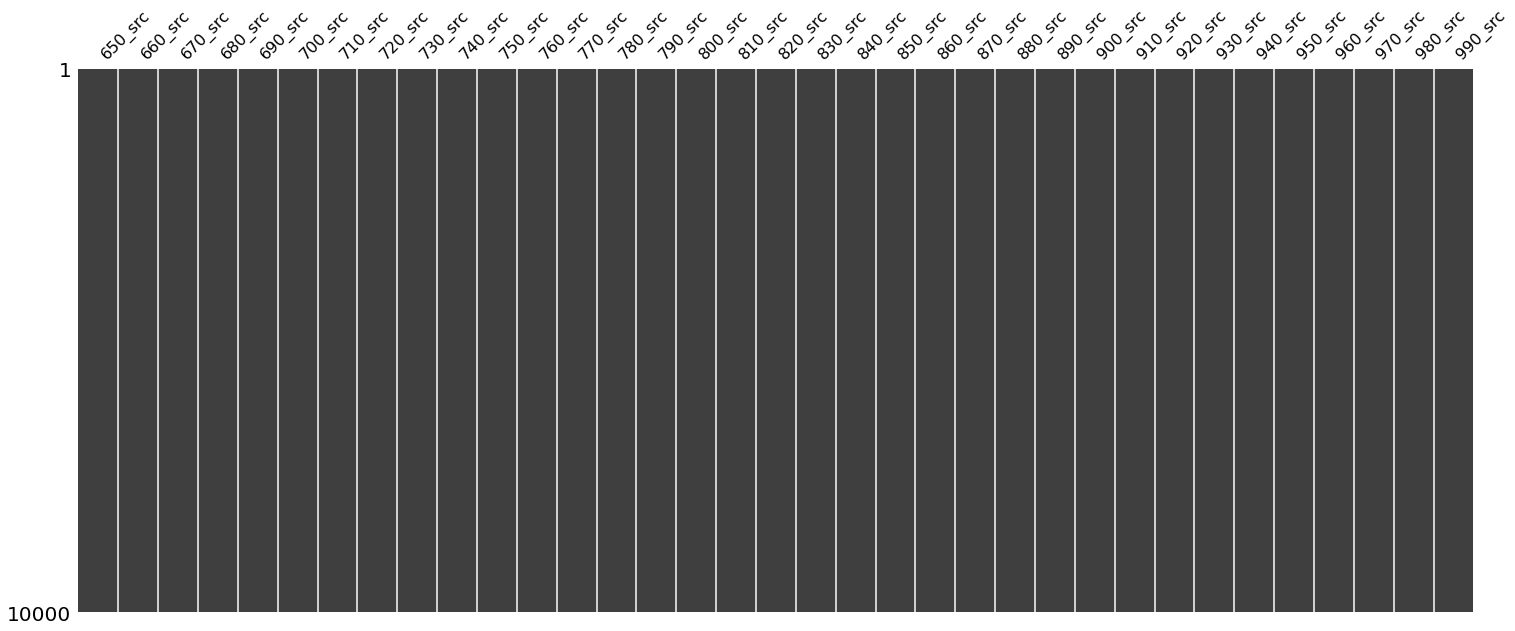

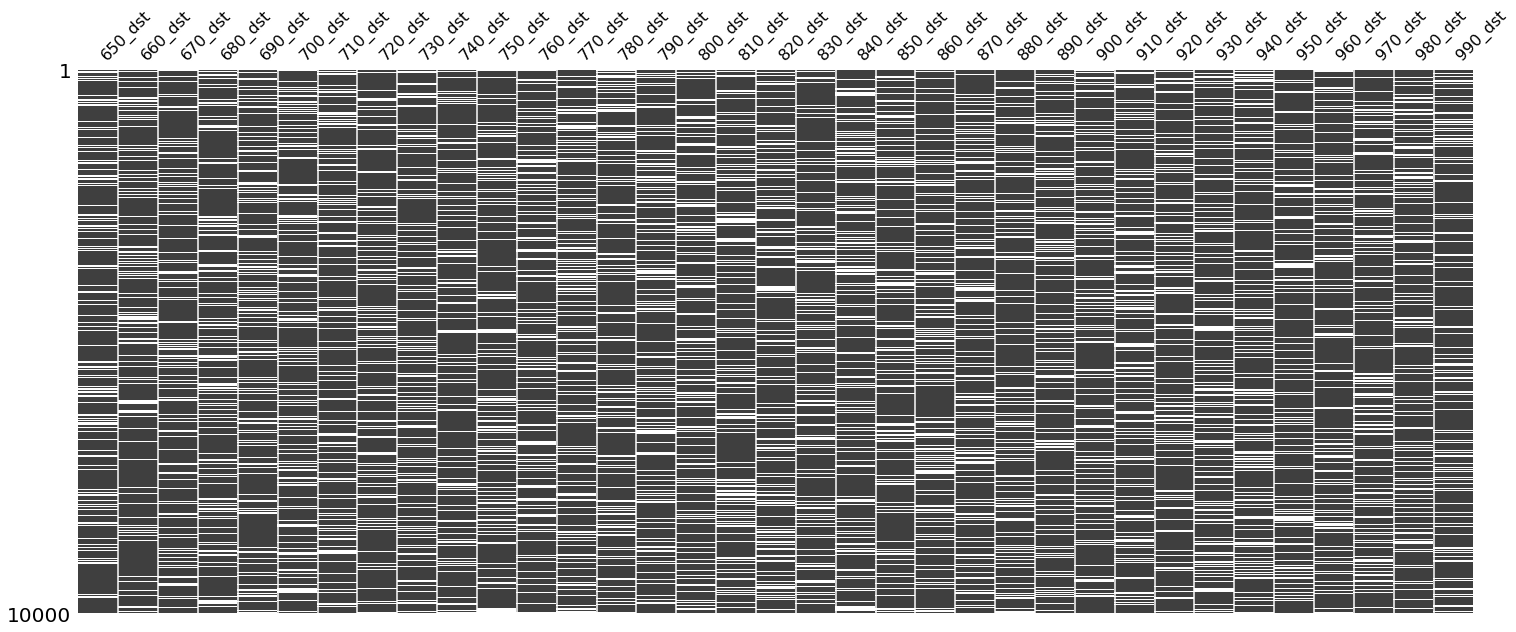

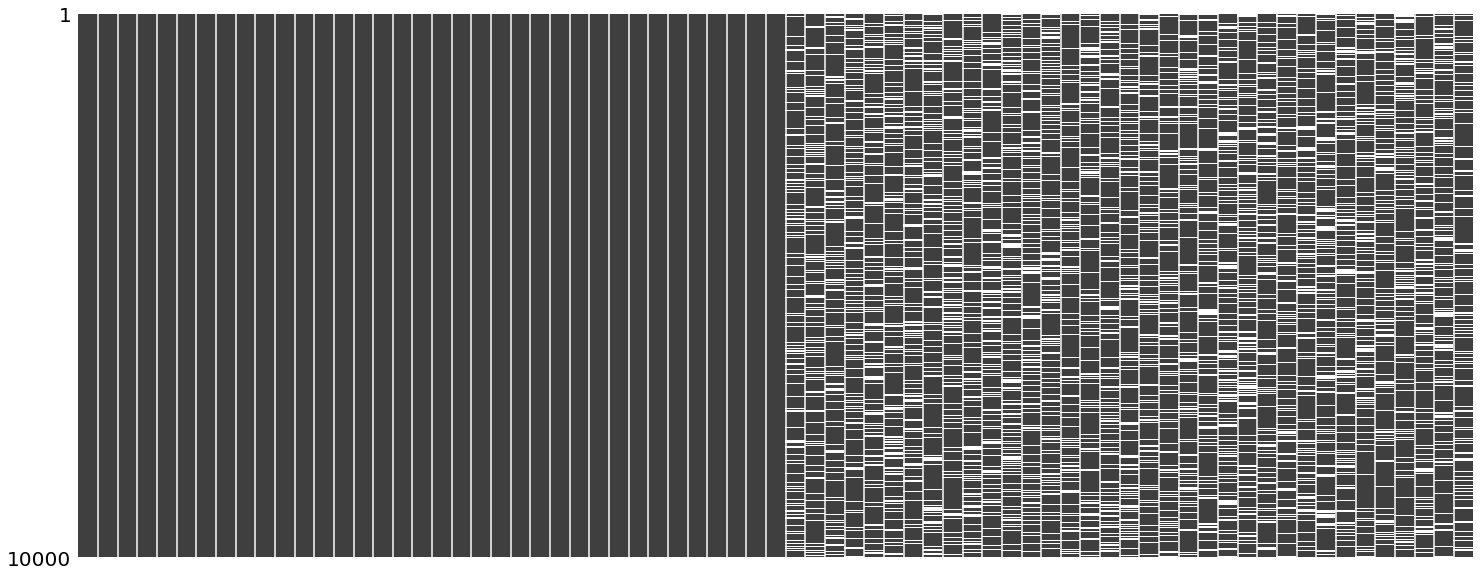

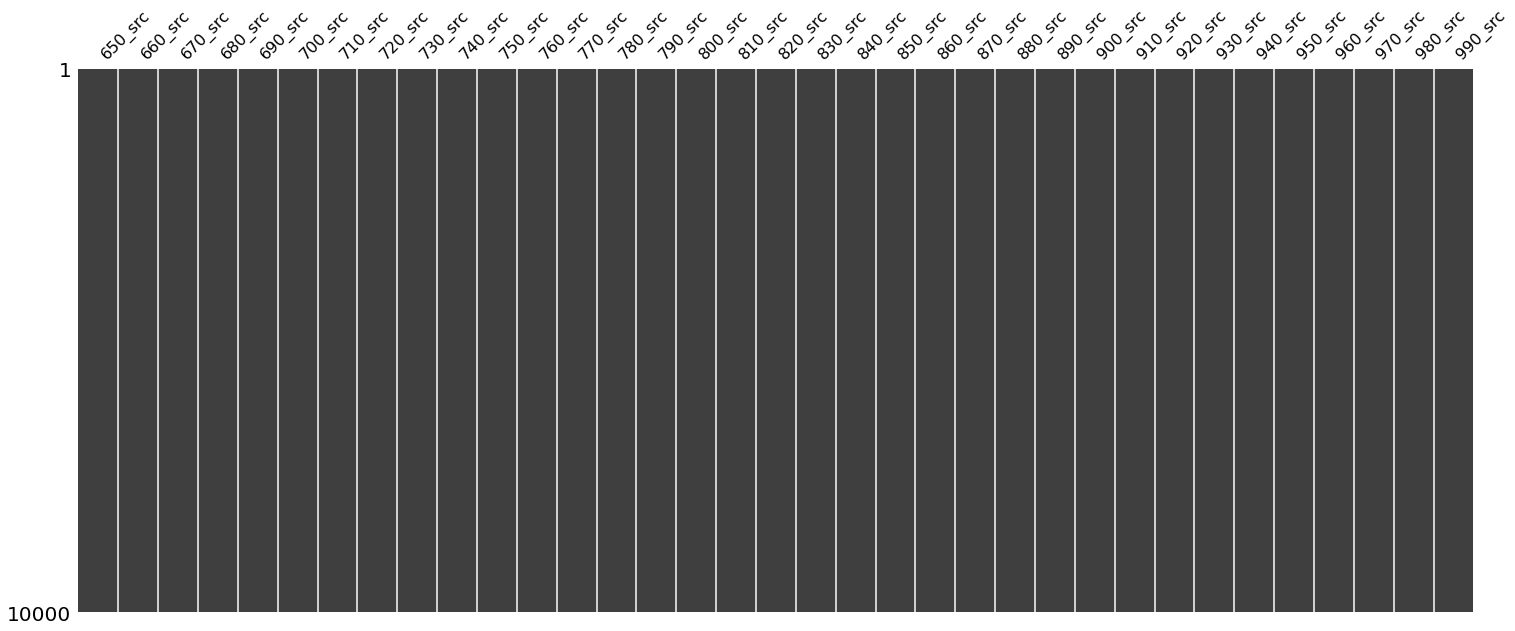

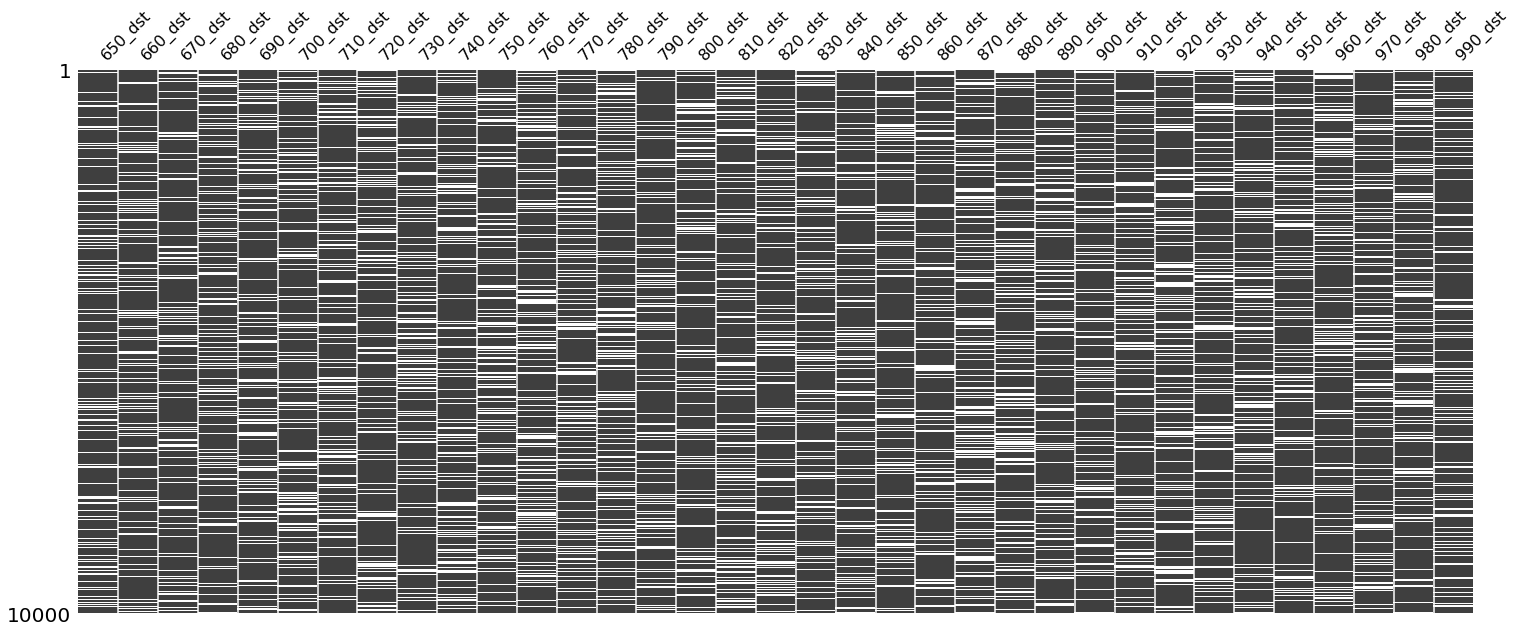

In [ ]:
# Train
msno.matrix(df= train, sparkline=False)
msno.matrix(df= train[src], sparkline=False) # clean
msno.matrix(df= train[dst], sparkline=False) # All dirty

# Test
msno.matrix(df= test, sparkline=False)
msno.matrix(df=test[src], sparkline=False)
msno.matrix(df=test[dst], sparkline=False)

In [ ]:
# Row wise number of missing
rows_with_missing=[]

for i in range(10000):
    missings= train.loc[i, train.loc[i].isnull()].shape[0]
    missing_perc= missings/35
    
    i_dict = {
        'row':i,
        'miss_count':missings,
        'miss_perc':missing_perc,
        }
    
    rows_with_missing.append(i_dict)
    
miss_row= pd.DataFrame(rows_with_missing, columns=['row', 'miss_count', 'miss_perc'])
miss_row.set_index('row', inplace=True)
miss_row

#min(miss_row.miss_count)
#max(miss_row.miss_count)
#miss_row[miss_row.miss_count==18]

,miss_count,miss_perc
row,,
0,10,0.285714
1,7,0.200000
2,10,0.285714
3,7,0.200000
4,8,0.228571
...,...,...
9995,6,0.171429
9996,8,0.228571
9997,5,0.142857


# Imputation

<Figure size 432x288 with 0 Axes>

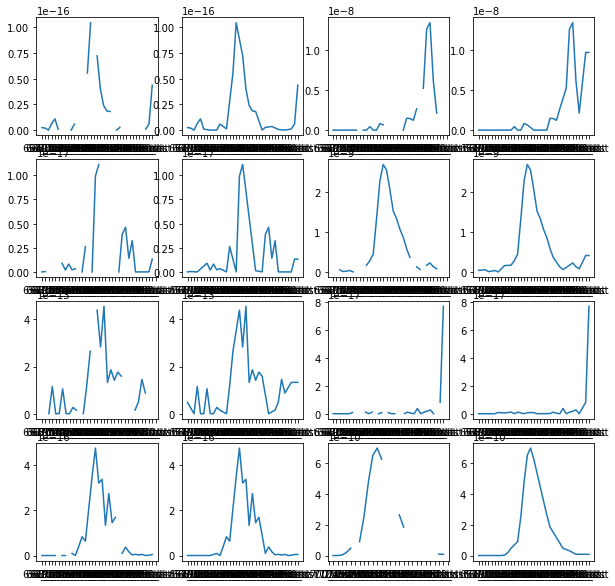

In [ ]:
# Imputation test
imput= train[dst].interpolate(methods='spline', order=4, axis=1, limit_direction='both')

plt.figure()
fig, ax= plt.subplots(4,4, figsize=(10, 10))

i=0
for obs in [0, 1, 2, 3, 4, 5, 11, 9075]:
  i+=1
  plt.subplot(4,4,i)
  plt.plot(train.loc[obs, dst])

  i+=1
  plt.subplot(4,4,i)
  plt.plot(imput.loc[obs, dst])

In [ ]:
train[dst]= train[dst].interpolate(methods='spline', order=4, axis=1, limit_direction='both')
test[dst]= test[dst].interpolate(methods='spline', order=4, axis=1, limit_direction='both')

In [ ]:
model_scoring_cv(multi_model, train, train_y)

Validation Time: 428.0 sec


3.910649056344242

# Outlier
## It needs imputation. Thus, after imputation

{'boxes': [<matplotlib.lines.Line2D at 0x7f3175b34f98>],
 'caps': [<matplotlib.lines.Line2D at 0x7f3175b349b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f317e9ff4e0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f317e9ffe80>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f3175b34b70>,
  <matplotlib.lines.Line2D at 0x7f3175b34fd0>]}

<Figure size 432x288 with 0 Axes>

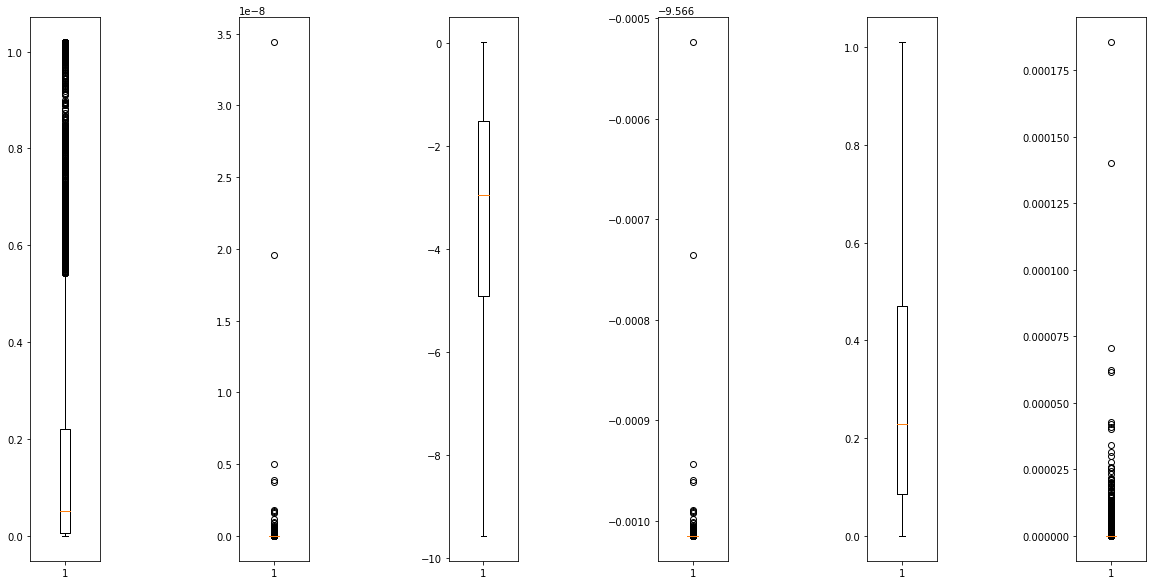

In [ ]:
plt.figure()
fig, ax= plt.subplots(1,6, figsize=(20, 10))#, figsize=(10, 10)
plt.subplots_adjust(wspace=2)

plt.subplot(1, 6, 1)
plt.boxplot(train['650_src'])
plt.subplot(1, 6, 2)
plt.boxplot(train['650_dst'])

# log transformation
plt.subplot(1, 6, 3)
plt.boxplot(np.log(train['650_src']+0.00007))
plt.subplot(1, 6, 4)
plt.boxplot(np.log(train['650_dst']+0.00007))

# sqrt transformation
plt.subplot(1, 6, 5)
plt.boxplot(np.sqrt(train['650_src']))
plt.subplot(1, 6, 6)
plt.boxplot(np.sqrt(train['650_dst']))

# If the dst is too high, lower the values

In [ ]:
for obs in range(10000):
  # max-min standardization
  x= train.loc[obs, dst]
  y= (x-0)/(x.max()-0) * 0.19

  x1= test.loc[obs, dst]
  y1= (x1-0)/(x1.max()-0) * 0.19

  for feature in range(35):
    if train.loc[obs, str(650+feature*10)+'_src'] < y[feature]:
      train.loc[obs, str(650+feature*10)+'_dst']= train.loc[obs, str(650+feature*10)+'_src'] * x.max() / 0.19 # Back to original scale

    if test.loc[obs, str(650+feature*10)+'_src'] < y1[feature]:
      test.loc[obs, str(650+feature*10)+'_dst']= test.loc[obs, str(650+feature*10)+'_src'] * x1.max() / 0.19

<Figure size 432x288 with 0 Axes>

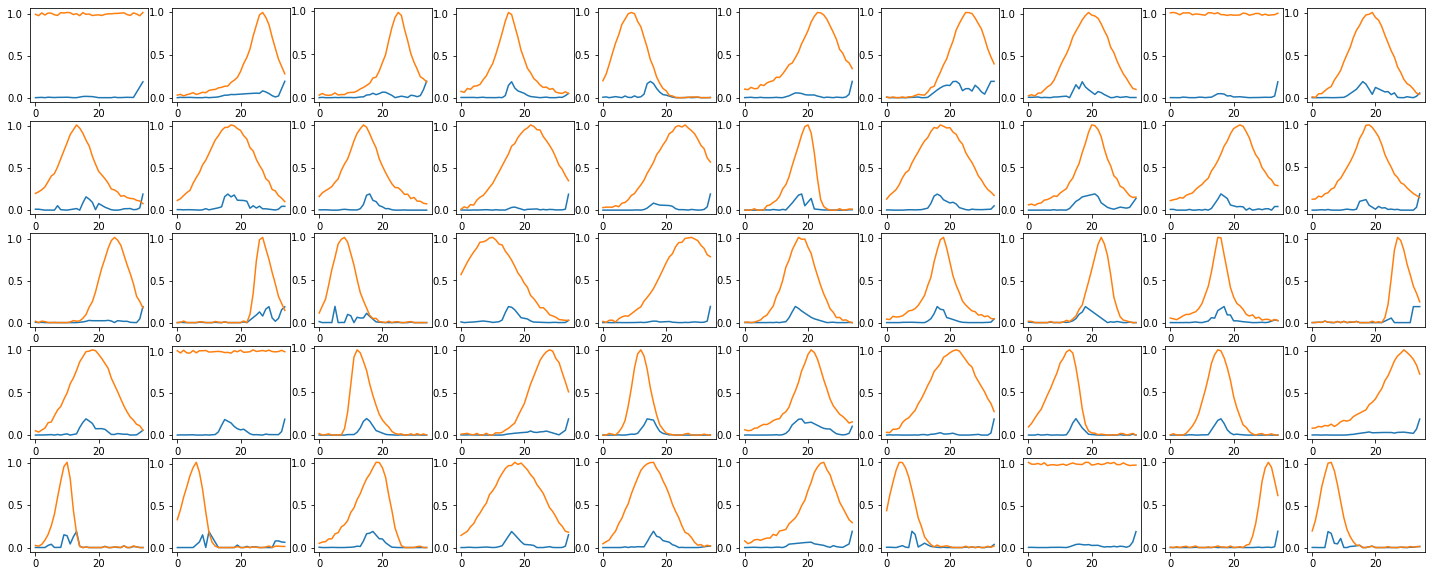

In [ ]:
plt.figure()
fig, ax = plt.subplots(5, 10, figsize=(25, 10))

i=0
for obs in np.arange(200, 250):
  i += 1
  plt.subplot(5,10,i)
  x= train.loc[obs, dst]
  x= (x-0)/(x.max()-0) * 0.19
  plt.plot(range(35), x)
  plt.plot(range(35), train.loc[obs, src])

## Destribution after the imputation
### Check whether the imputation is done well

<Figure size 432x288 with 0 Axes>

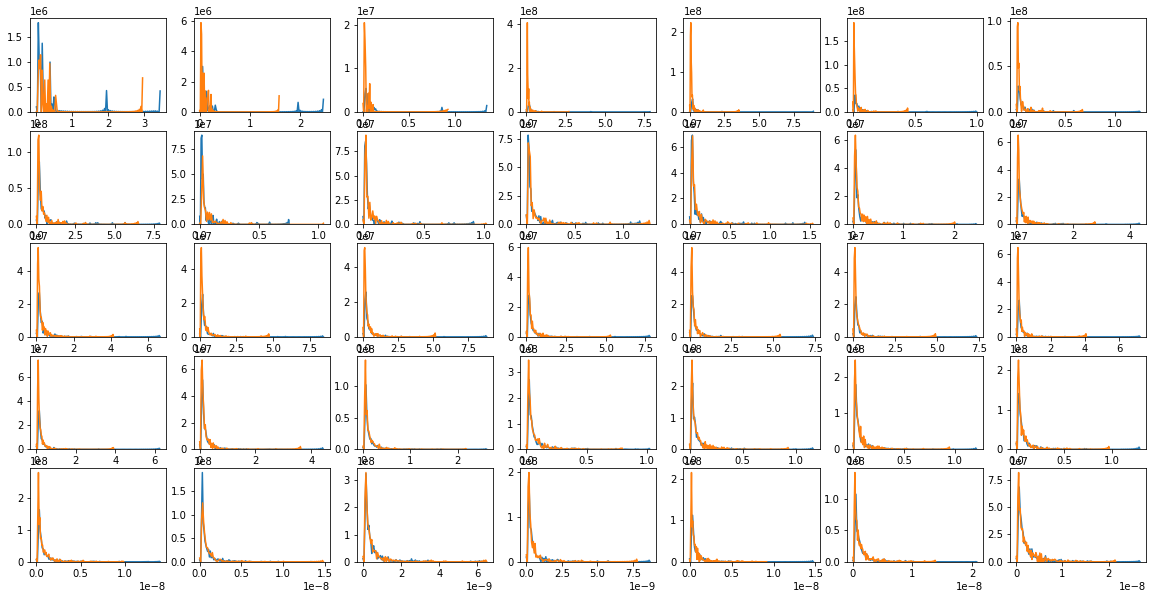

In [ ]:
# Density plot of input variables in train & test
# Eventhogh imputed, the density of dst variables are different!!!
# Eventhogh the distributions of variables are different in train & test '650_dst', '660_dst', Use them all!!!

plt.figure()
fig, ax = plt.subplots(5, 7, figsize=(20, 10)) # figsize=(h, v)

i= 0
for feature in dst:
    i += 1
    plt.subplot(5, 7, i)
    
    sns.kdeplot(train[feature], legend=False)
    sns.kdeplot(test[feature], legend=False)
    #plt.xlabel(feature, fontsize= 10)
plt.show();

## Correlation of input variables

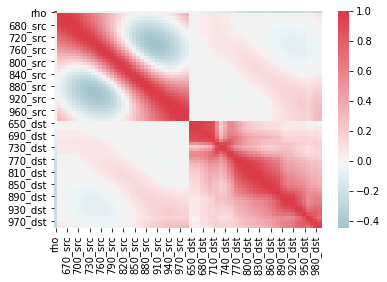

In [ ]:
cmap=sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train.corr(), center= 0, annot=False, cmap=cmap)
# rho is independent of src, but has negative relation with dst

## Scatter plot

In [ ]:
# To many plots!!! (5041!!!)
# Do not try!!!
# sns.pairplot(train[input], diag_kind='kde')

# Target 

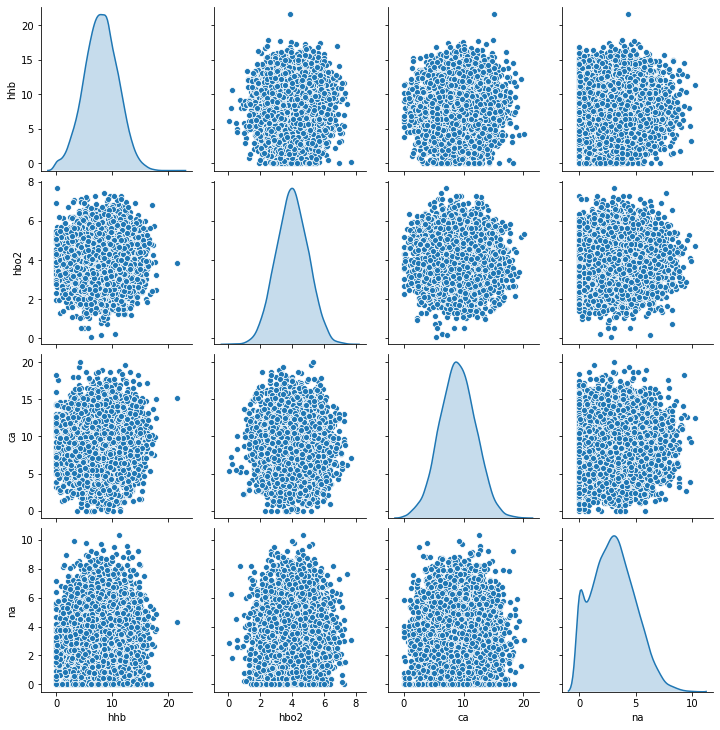

In [ ]:
# scatter plot of target variables
sns.pairplot(train_y, diag_kind='kde')

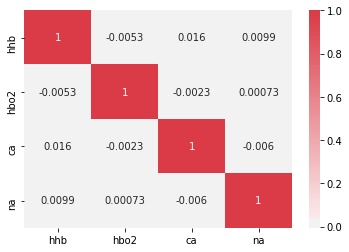

In [ ]:
# Correlation of target variables
sns.heatmap(train_y.corr(), cmap=cmap, center= 0, annot=True)

<Figure size 432x288 with 0 Axes>

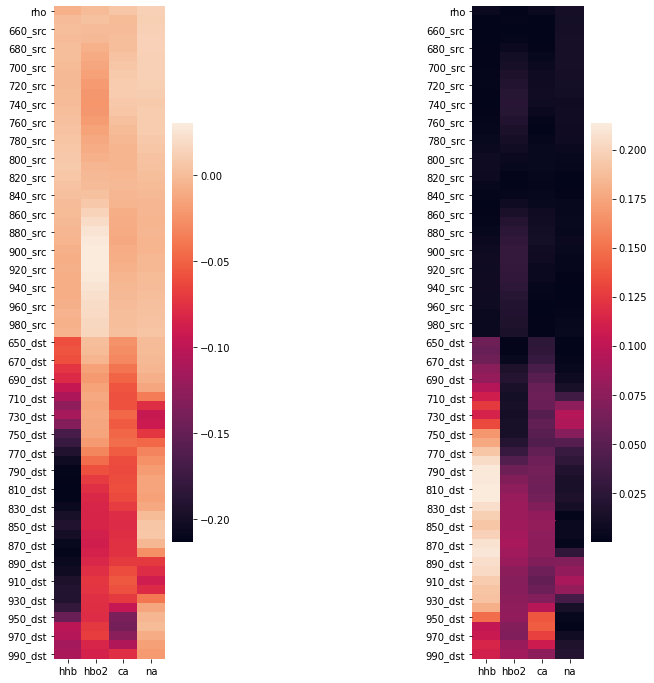

In [ ]:
# Target & input
plt.figure()
fig, ax = plt.subplots(1, 2 , figsize=(10, 12))
plt.subplots_adjust(wspace=2)

plt.subplot(1, 2, 1)
sns.heatmap(pd.concat((train, train_y), axis=1).corr().loc['rho':'990_dst', 'hhb':])# , vmin=-0.3, vmax=0.3
plt.subplot(1, 2, 2)
sns.heatmap(pd.concat((train, train_y), axis=1).corr().loc['rho':'990_dst', 'hhb':].abs())
# dst have negative relation

<Figure size 432x288 with 0 Axes>

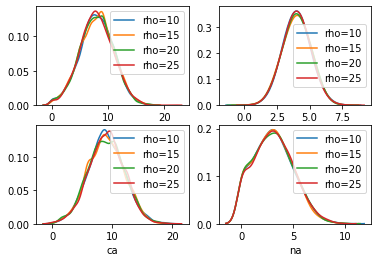

In [ ]:
# rho variable
plt.figure()
fig, ax = plt.subplots(2,2)

i=0
for feature in target:
    i +=1
    plt.subplot(2,2,i)
    sns.kdeplot(pd.concat((train, train_y), axis=1).loc[train.rho==10, feature], bw=0.5, label="rho=10")
    sns.kdeplot(pd.concat((train, train_y), axis=1).loc[train.rho==15, feature], bw=0.5, label="rho=15")
    sns.kdeplot(pd.concat((train, train_y), axis=1).loc[train.rho==20, feature], bw=0.5, label="rho=20")
    sns.kdeplot(pd.concat((train, train_y), axis=1).loc[train.rho==25, feature], bw=0.5, label="rho=25")
    plt.xlabel(feature, fontsize=10)

# New variables
## 1) The Strenght of light is propotional to the 1/distance^2.
So, standardize the variables.

# Choose which to use as dst
i) original dst\
ii) rho square dst\
ii) max min dst

In [ ]:
# run only once
for feature in dst:
  train[feature]=train[feature]*train['rho']**2
  test[feature]=test[feature]*train['rho']**2

## 2) max-min standardized
min = 0

In [ ]:
# run only once
for obs in range(10000):
  x= train.loc[obs, dst]
  train.loc[obs, dst]= (x-0)/(x.max()-0) * 0.19
  
  x1= test.loc[obs, dst]
  test.loc[obs, dst]= (x1-0)/(x1.max()-0) * 0.19

## 3) src - dst gap

In [ ]:
for feature in np.arange(650, 1000, 10):
  train[str(feature) + '_gap']= train[str(feature)+'_src']-train[str(feature)+'_dst']
  test[str(feature) + '_gap']= test[str(feature)+'_src']-test[str(feature)+'_dst']

## 4) dst / src ratio

In [ ]:
for feature in np.arange(650, 1000, 10):
  # If src is 0, then dst is 0 (maybe)
  train.loc[(train[str(feature)+'_src']==0), str(feature)+'_dst']= 0
  train[str(feature) + '_ratio']= train[str(feature)+'_dst'] / train[str(feature)+'_src']
  
  test.loc[(test[str(feature)+'_src']==0), str(feature)+'_dst']= 0
  test[str(feature) + '_ratio']= test[str(feature)+'_dst'] / test[str(feature)+'_src']

# If src is 0, the ratio becomes NaN
train[train.isna()]= 0
test[test.isna()]= 0

## 5) Fourier transformation (DFT)
As it's wave data.

In [ ]:
alpha_real=train[dst]
alpha_imag=train[dst]

beta_real=test[dst]
beta_imag=test[dst]

for i in alpha_real.index:
    alpha_real.loc[i]=alpha_real.loc[i] - alpha_real.loc[i].mean()
    alpha_imag.loc[i]=alpha_imag.loc[i] - alpha_real.loc[i].mean()
    
    alpha_real.loc[i] = np.fft.fft(alpha_real.loc[i], norm='ortho').real
    alpha_imag.loc[i] = np.fft.fft(alpha_imag.loc[i], norm='ortho').imag

    
for i in beta_real.index:
    beta_real.loc[i]=beta_real.loc[i] - beta_real.loc[i].mean()
    beta_imag.loc[i]=beta_imag.loc[i] - beta_imag.loc[i].mean()
    
    beta_real.loc[i] = np.fft.fft(beta_real.loc[i], norm='ortho').real
    beta_imag.loc[i] = np.fft.fft(beta_imag.loc[i], norm='ortho').imag
    
real_part=[]
imag_part=[]

for col in dst:
    real_part.append(col + '_fft_real')
    imag_part.append(col + '_fft_imag')
    
alpha_real.columns=real_part
alpha_imag.columns=imag_part
alpha = pd.concat((alpha_real, alpha_imag), axis=1)

beta_real.columns=real_part
beta_imag.columns=imag_part
beta=pd.concat((beta_real, beta_imag), axis=1)

train=pd.concat((train, alpha), axis=1)
test=pd.concat((test, beta), axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-pack

## 6) rho as dummy variable

In [ ]:
rhos= pd.get_dummies(train['rho'])
rhos.columns= ['ten', 'fif', 'twen', 'twenf']

rhos_test= pd.get_dummies(test['rho'])
rhos_test.columns= ['ten', 'fif', 'twen', 'twenf']

for feature in dst:
  train[feature+'_rho_dum10']= train[feature]*rhos['ten']
  train[feature+'_rho_dum15']= train[feature]*rhos['fif']
  train[feature+'_rho_dum20']= train[feature]*rhos['twen']
  train[feature+'_rho_dum25']= train[feature]*rhos['twenf']
  
  test[feature+'_rho_dum10']= test[feature]*rhos_test['ten']
  test[feature+'_rho_dum15']= test[feature]*rhos_test['fif']
  test[feature+'_rho_dum20']= test[feature]*rhos_test['twen']
  test[feature+'_rho_dum25']= test[feature]*rhos_test['twenf']

# 7) interactions & square variables

In [ ]:
# Run only once!!!
poly= PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

interactions= pd.DataFrame(data=poly.fit_transform(train[inputs]), columns=poly.get_feature_names(inputs))
interactions= interactions.drop(columns=inputs)
train= pd.concat((train, interactions), axis=1)
#interactions# 2627 is right number

# test set
interactions_test= pd.DataFrame(data=poly.fit_transform(test[inputs]), columns=poly.get_feature_names(inputs))
interactions_test= interactions_test.drop(columns=inputs)
test= pd.concat((test, interactions_test), axis=1)

## 8) The differentiateion

In [ ]:
for feature in np.arange(650, 990, 10):
  train[str(feature)+'th_dif']= train[str(feature+10)+'_dst']-train[str(feature)+'_dst']
  test[str(feature)+'th_dif']= test[str(feature+10)+'_dst']-test[str(feature)+'_dst']

## 9) Peak
Peak value and location

In [ ]:
for obs in np.arange(0, 10000):
  x= train.loc[obs, dst].max()
  y= test.loc[obs, dst].max()

  train.loc[obs, 'dst_peak']= x
  test.loc[obs, 'dst_peak']= y

  train.loc[obs, 'dst_peak_loc']= list(train.loc[obs, dst]).index(x)
  test.loc[obs, 'dst_peak_loc']= list(test.loc[obs, dst]).index(y)

### Overall number of variables

In [ ]:
train.shape

(10000, 2943)

# Variable selection

In [ ]:
# np.arrange(100, 700, 100) -> 200 is selected
# np.arange(290, 80, -30) -> 200 is selected
# np.arange(229, 191, -1) -> 217 is selected

tmp= np.repeat(True, train.shape[1])
train_tmp= train
for n_feature in np.arange(229, 170, -1): # In decreasing way, to speed up
  # Get selected variables of n
  selector= RFE(base_model, n_features_to_select=n_feature, step=0.1)
  train_hhb= selector.fit(train_tmp, train_y['hhb'])
  #train_hbo2= selector.fit(train, train_y['hbo2'])
  #train_ca= selector.fit(train, train_y['ca'])
  #train_na= selector.fit(train, train_y['na'])
  
  # Get model score
  print('Using', n_feature, 'features')
  print(model_scoring_cv(base_model, train_tmp.loc[:, train_hhb.support_], train_y['hhb']))

  tmp= train_hhb.support_
  train_tmp= train_tmp.loc[:, tmp]

#train_hhb.ranking_

In [ ]:
selector= RFE(base_model, n_features_to_select=217, step=0.3)
train_hhb= selector.fit(train, train_y['hhb'])
#train_hbo2= selector.fit(train, train_y['hbo2'])
#train_ca= selector.fit(train, train_y['ca'])
#train_na= selector.fit(train, train_y['na'])

In [ ]:
train.loc[:, train_hhb.support_].columns

Index(['rho', '770_src', '780_src', '790_src', '800_src', '810_src', '820_src',
       '830_src', '840_src', '850_src',
       ...
       '860th_dif', '870th_dif', '880th_dif', '930th_dif', '940th_dif',
       '950th_dif', '960th_dif', '980th_dif', 'dst_peak', 'dst_peak_loc'],
      dtype='object', length=217)

# parameter tuning & **Prediction**
## 1) hhb

In [ ]:
lgbm= LGBMRegressor(random_state=1589, n_estimators=900, subsample=0.9, boosting_type='dart', objective='regression_l1', learning_rate=0.16, max_depth=30,
                    colsample_bytree=0.8, min_child_samples=60)

params= {'num_leaves': [100, 1000, 10000]}
#params= {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'], 'min_child_samples': [70, 60, 50, 5], 'subsample': [1, 0.9, 0.8, 0.7]}
#'n_estimators': [1000, 900, 800, 700, 600, 500, 400, 300, 200] -> 900
#'objective': ['regression', 'regression_l1', 'huber', 'fair', 'quantile', 'mape'] -> regression
#'learning_rate':[0.2, 0.17, 0.16, 0.15, 0.1, 0.05]-> 0.16
#'max_depth': [40, 35, 31, 30, 29, 25, 20]-> 30

grid= GridSearchCV(lgbm, param_grid= params)# verbose=100
grid.fit(train.loc[:, train_hhb.support_], train_y['hhb'])# , early_stopping_rounds=100, eval_metric="MAE"

grid.best_params_

In [ ]:
lgbm= LGBMRegressor(random_state=143, n_estimators=900, subsample=0.9, boosting_type='dart', objective='regression_l1', learning_rate=0.16, max_depth=30,
                    colsample_bytree=0.8, min_child_samples=60)#, num_leaves=90, reg_alpha=5, reg_lambda=7, subsample_freq=1, importance_type='gain', silent=False, **grid.best_params_

lgbm.fit(train.loc[:, train_hhb.support_], train_y['hhb'])

pred_hhb= lgbm.predict(test.loc[:, train_hhb.support_])

## 2) hbo2

In [ ]:
lgbm= LGBMRegressor(random_state=1003, subsample=0.9, min_child_samples=60, boosting_type='dart', objective='regression', learning_rate=0.16)

grid2= GridSearchCV(lgbm, param_grid= params)
grid2.fit(train.loc[:, train_hhb.support_], train_y['hbo2']) #, early_stopping_rounds=100, eval_metric="MAE"

grid2.best_params_

{'n_estimators': 1000}

In [ ]:
lgbm= LGBMRegressor(random_state=19, n_estimators=900, subsample=0.9, boosting_type='dart', objective='regression_l1', learning_rate=0.16, max_depth=30,
                    colsample_bytree=0.8, min_child_samples=60)# **grid2.best_params_
lgbm.fit(train.loc[:, train_hhb.support_], train_y['hbo2'])

pred_hbo2= lgbm.predict(test.loc[:, train_hhb.support_])

## 3) ca

In [ ]:
lgbm= LGBMRegressor(random_state=1003, subsample=0.9, min_child_samples=60, boosting_type='dart', objective='regression', learning_rate=0.16)

grid3= GridSearchCV(lgbm, param_grid= params)
grid3.fit(train.loc[:, train_hhb.support_], train_y['ca']) #, early_stopping_rounds=100, eval_metric="MAE"

grid3.best_params_

{'n_estimators': 1000}

In [ ]:
lgbm= LGBMRegressor(random_state=19, n_estimators=900, subsample=0.9, boosting_type='dart', objective='regression_l1', learning_rate=0.16, max_depth=30,
                    colsample_bytree=0.8, min_child_samples=60)#, **grid3.best_params_
lgbm.fit(train.loc[:, train_hhb.support_], train_y['ca'])

pred_ca= lgbm.predict(test.loc[:, train_hhb.support_])

## 4) na

In [ ]:
lgbm= LGBMRegressor(random_state=1003, subsample=0.9, min_child_samples=60, boosting_type='dart', objective='regression', learning_rate=0.16)

grid4= GridSearchCV(lgbm, param_grid= params)
grid4.fit(train.loc[:, train_hhb.support_], train_y['na']) #, early_stopping_rounds=100, eval_metric="MAE"

grid4.best_params_

In [ ]:
lgbm= LGBMRegressor(random_state=19, n_estimators=900, subsample=0.9, boosting_type='dart', objective='regression_l1', learning_rate=0.16, max_depth=30,
                    colsample_bytree=0.8, min_child_samples=60)#, **grid4.best_params_
lgbm.fit(train.loc[:, train_hhb.support_], train_y['na'])

pred_na= lgbm.predict(test.loc[:, train_hhb.support_])

# Stacking

In [ ]:
models = [ ExtraTreesRegressor(random_state = 109, n_jobs = -1, n_estimators = 600, max_depth = 3),
          RandomForestRegressor(random_state = 109, n_jobs = -1, n_estimators = 600, max_depth = 3),
          XGBRegressor(seed = 109, n_jobs = -1, learning_rate = 0.1, n_estimators = 600, max_depth = 3, early_stopping_rounds= 100)]

In [ ]:
S_train, S_test = stacking(models, train.loc[:, train_hhb.support_], train_y['hhb'], test.loc[:, train_hhb.support_], regression = True, n_folds = 5, stratified = True, shuffle = True, random_state = 0, verbose = 2)

lgbm= LGBMRegressor(random_state=109, n_estimators=1000, subsample=0.9, min_child_samples=60, boosting_type='dart', objective='regression', learning_rate=0.16)# **grid.best_params_
lgbm.fit(S_train, train_y['hhb'])

pred_hhb= lgbm.predict(S_test)

/usr/local/lib/python3.6/dist-packages/vecstack/core.py:461: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [ExtraTreesRegressor]
    fold  0:  [2.12225722]
    fold  1:  [2.16553015]
    fold  2:  [2.15241593]
    fold  3:  [2.10404267]
    fold  4:  [2.15843210]
    ----
    MEAN:     [2.14053561] + [0.02346055]
    FULL:     [2.14053561]

model  1:     [RandomForestRegressor]
    fold  0:  [2.24255454]
    fold  1:  [2.25573944]
    fold  2:  [2.28929578]
    fold  3:  [2.23128334]
    fold  4:  [2.24121832]
    ----
    MEAN:     [2.25201828] + [0.02019702]
    FULL:     [2.25201828]

model  2:     [XGBRegressor]
[17:05:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [0.83728759]
[17:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [0.82352698]
[17:06:32] WARNING: /workspace/src/objective/regre

In [ ]:
S_train, S_test = stacking(models, train.loc[:, train_hhb.support_], train_y['hbo2'], test.loc[:, train_hhb.support_], regression = True, n_folds = 5, stratified = True, shuffle = True, random_state = 0, verbose = 2)

lgbm= LGBMRegressor(random_state=109, n_estimators=1000, subsample=0.9, min_child_samples=60, boosting_type='dart', objective='regression', learning_rate=0.16)# **grid.best_params_
lgbm.fit(S_train, train_y['hbo2'])

pred_hbo2= lgbm.predict(S_test)

/usr/local/lib/python3.6/dist-packages/vecstack/core.py:461: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [ExtraTreesRegressor]
    fold  0:  [0.79454802]
    fold  1:  [0.77117473]
    fold  2:  [0.75884470]
    fold  3:  [0.79189811]
    fold  4:  [0.79936503]
    ----
    MEAN:     [0.78316612] + [0.01551467]
    FULL:     [0.78316612]

model  1:     [RandomForestRegressor]
    fold  0:  [0.80371444]
    fold  1:  [0.77853992]
    fold  2:  [0.77109771]
    fold  3:  [0.80143851]
    fold  4:  [0.81172086]
    ----
    MEAN:     [0.79330229] + [0.01565136]
    FULL:     [0.79330229]

model  2:     [XGBRegressor]
[17:17:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [0.59453609]
[17:18:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [0.59315782]
[17:19:00] WARNING: /workspace/src/objective/regre

In [ ]:
S_train, S_test = stacking(models, train.loc[:, train_hhb.support_], train_y['ca'], test.loc[:, train_hhb.support_], regression = True, n_folds = 5, stratified = True, shuffle = True, random_state = 0, verbose = 2)

lgbm= LGBMRegressor(random_state=109, n_estimators=1000, subsample=0.9, min_child_samples=60, boosting_type='dart', objective='regression', learning_rate=0.16)# **grid.best_params_
lgbm.fit(S_train, train_y['ca'])

pred_ca= lgbm.predict(S_test)

/usr/local/lib/python3.6/dist-packages/vecstack/core.py:461: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [ExtraTreesRegressor]
    fold  0:  [2.31605580]
    fold  1:  [2.32370307]
    fold  2:  [2.37071504]
    fold  3:  [2.33591567]
    fold  4:  [2.35002375]
    ----
    MEAN:     [2.33928267] + [0.01947774]
    FULL:     [2.33928267]

model  1:     [RandomForestRegressor]
    fold  0:  [2.32850033]
    fold  1:  [2.32210671]
    fold  2:  [2.39663300]
    fold  3:  [2.35200138]
    fold  4:  [2.34791132]
    ----
    MEAN:     [2.34943055] + [0.02615972]
    FULL:     [2.34943055]

model  2:     [XGBRegressor]
[17:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [1.86216253]
[17:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [1.88337379]
[17:30:53] WARNING: /workspace/src/objective/regre

In [ ]:
S_train, S_test = stacking(models, train.loc[:, train_hhb.support_], train_y['na'], test.loc[:, train_hhb.support_], regression = True, n_folds = 5, stratified = True, shuffle = True, random_state = 0, verbose = 2)

lgbm= LGBMRegressor(random_state=109, n_estimators=900, subsample=0.9, min_child_samples=60, boosting_type='dart', objective='regression', learning_rate=0.16)# **grid.best_params_
lgbm.fit(S_train, train_y['na'])

pred_na= lgbm.predict(S_test)

/usr/local/lib/python3.6/dist-packages/vecstack/core.py:461: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [ExtraTreesRegressor]
    fold  0:  [1.51125171]
    fold  1:  [1.54370823]
    fold  2:  [1.53613096]
    fold  3:  [1.52407230]
    fold  4:  [1.45457438]
    ----
    MEAN:     [1.51394751] + [0.03166308]
    FULL:     [1.51394751]

model  1:     [RandomForestRegressor]
    fold  0:  [1.53311922]
    fold  1:  [1.56067466]
    fold  2:  [1.56008071]
    fold  3:  [1.54919462]
    fold  4:  [1.47348892]
    ----
    MEAN:     [1.53531163] + [0.03248502]
    FULL:     [1.53531163]

model  2:     [XGBRegressor]
[17:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [1.25350233]
[17:42:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [1.23856112]
[17:43:14] WARNING: /workspace/src/objective/regre

## merge

In [ ]:
pred_dict = {'id': np.arange(10000, 20000), 'hhb': pred_hhb, 'hbo2': pred_hbo2, 'ca': pred_ca, 'na':pred_na}
result= pd.DataFrame(pred_dict)
result

,id,hhb,hbo2,ca,na
0,10000,-0.289090,0.135958,8.287481,2.881389
1,10001,0.044542,-0.992927,9.620180,1.583591
2,10002,-0.703940,-0.480906,9.059085,3.086207
3,10003,0.135504,0.137850,8.941313,4.063218
4,10004,-0.900379,-0.453495,9.384183,2.860036
...,...,...,...,...,...
9995,19995,-2.019032,0.434349,10.980624,3.572778
9996,19996,2.192842,-1.158032,5.298929,2.929371
9997,19997,0.660420,-0.006003,8.709906,3.493078
9998,19998,2.822999,0.286965,11.203840,3.406429


In [ ]:
result.to_csv("result.csv", header=True, index=False)